# ETH DeepLOB Classifier - Normalized Features

Train a DeepLOB CNN-LSTM model using normalized order book features for 3-class prediction (bearish/bullish/neutral).

## 1. Imports & Setup

In [41]:
import pandas as pd
import numpy as np
import json
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, LSTM, Dense, Dropout, Reshape, MaxPooling2D, concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical

from sklearn.utils import class_weight

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.18.0
GPU available: False


## 2. Load Combined Dataset

In [ ]:
# Load combined dataset (UNSCALED - will scale properly after split)
X = np.load('combined_X_sequences.npy')
y = np.load('combined_y_labels.npy')
dataset_id = np.load('combined_dataset_id.npy')  # NEW: Dataset origin tracking

# Load metadata
with open('combined_dataset_metadata.json', 'r') as f:
    metadata = json.load(f)

print(f"="*80)
print(f"LOADED COMBINED DATASET")
print(f"="*80)
print(f"  X shape: {X.shape}  # (samples, timesteps, features)")
print(f"  y shape: {y.shape}")
print(f"  dataset_id shape: {dataset_id.shape}")
print(f"\n  Total samples: {metadata['total_samples']:,}")
print(f"  Sequence length (T): {metadata['sequence_length']}")
print(f"  Number of features (F): {metadata['num_features']}")
print(f"  Horizon: {metadata['horizon']} minutes")
print(f"  Threshold: {metadata['threshold']*100:.1f}%")

print(f"\n{'-'*80}")
print(f"DATASET COMPOSITION")
print(f"{'-'*80}")
for dataset_idx in sorted(np.unique(dataset_id)):
    mask = (dataset_id == dataset_idx)
    n_samples = mask.sum()
    print(f"  Dataset {dataset_idx} ({metadata['dataset_names'][dataset_idx]})")
    print(f"    Sequences: {n_samples} ({100*n_samples/len(dataset_id):.1f}%)")

print(f"\n{'-'*80}")
print(f"CLASS DISTRIBUTION (COMBINED)")
print(f"{'-'*80}")
for cls in range(3):
    cls_count = np.sum(y == cls)
    print(f"  Class {cls}: {cls_count} ({100*cls_count/len(y):.1f}%)")
print(f"\nNOTE: Data is UNSCALED - will apply scaling after chronological split")

Loaded FILTERED dataset:
  X shape: (7707, 60, 86)
  y shape: (7707,)
  Total samples: 7,707
  Sequence length: 60
  Original features: 86
  Filtered features: 33
  Features removed: 53

Class distribution:
  0=DOWN: 3901 (50.6%)
  1=UP:   3806 (49.4%)

Label parameters:
  Horizon: 5 minutes
  Threshold: 0.3%

Feature selection criteria:
  Removed high correlation pairs: 31
  Removed low variance features: 0


## 3. Chronological Train/Val/Test Split

**CRITICAL**: Split by time, NOT randomly, to prevent data leakage and simulate production.

In [ ]:
# Time-based split: 70% train / 15% val / 15% test
# NO SHUFFLING - preserve chronological order
n = len(X)
train_end = int(0.70 * n)
val_end = int(0.85 * n)

X_train_raw = X[:train_end]
y_train = y[:train_end]
dataset_id_train = dataset_id[:train_end]

X_val_raw = X[train_end:val_end]
y_val = y[train_end:val_end]
dataset_id_val = dataset_id[train_end:val_end]

X_test_raw = X[val_end:]
y_test = y[val_end:]
dataset_id_test = dataset_id[val_end:]

print(f"="*80)
print(f"CHRONOLOGICAL SPLIT")
print(f"="*80)
print(f"  Train: {len(X_train_raw):,} samples ({100*len(X_train_raw)/n:.1f}%)")
print(f"  Val:   {len(X_val_raw):,} samples ({100*len(X_val_raw)/n:.1f}%)")
print(f"  Test:  {len(X_test_raw):,} samples ({100*len(X_test_raw)/n:.1f}%)")

# Per-split diagnostics
def print_split_stats(X, y, dset_id, name):
    print(f"\n{'-'*80}")
    print(f"{name} SET STATISTICS")
    print(f"{'-'*80}")
    
    # Dataset composition
    for d in sorted(np.unique(dset_id)):
        mask = (dset_id == d)
        print(f"  Dataset {d}: {mask.sum()} samples ({100*mask.sum()/len(dset_id):.1f}%)")
    
    # Class distribution
    print(f"\n  Class distribution:")
    for cls in range(3):
        cls_count = np.sum(y == cls)
        print(f"    Class {cls}: {cls_count} ({100*cls_count/len(y):.1f}%)")

print_split_stats(X_train_raw, y_train, dataset_id_train, "TRAIN")
print_split_stats(X_val_raw, y_val, dataset_id_val, "VAL")
print_split_stats(X_test_raw, y_test, dataset_id_test, "TEST")

## 4. Feature Scaling (Train-Set Statistics Only)

**CRITICAL**: Compute mean/std on training set only, then apply to val/test to prevent data leakage.

In [ ]:
# X shape: (N, T, F) where T=timesteps, F=features
# We need to compute statistics treating sequences correctly

T = X_train_raw.shape[1]  # timesteps
F = X_train_raw.shape[2]  # features

print(f"="*80)
print(f"FEATURE SCALING (TRAIN-SET STATISTICS ONLY)")
print(f"="*80)
print(f"  Input shape: (samples={X_train_raw.shape[0]}, timesteps={T}, features={F})")

# Flatten train sequences to (N*T, F) for computing statistics
X_train_flat = X_train_raw.reshape(-1, F)

print(f"  Flattened train: {X_train_flat.shape}")

# Compute mean and std across all timesteps and samples (per feature)
feature_mean = X_train_flat.mean(axis=0)
feature_std = X_train_flat.std(axis=0) + 1e-8  # Add epsilon to avoid division by zero

print(f"\n  Feature statistics computed on {X_train_flat.shape[0]:,} observations")
print(f"  Mean range: [{feature_mean.min():.6f}, {feature_mean.max():.6f}]")
print(f"  Std range:  [{feature_std.min():.6f}, {feature_std.max():.6f}]")

# Save scaling parameters for later use (e.g., production inference)
np.save('train_feature_mean.npy', feature_mean)
np.save('train_feature_std.npy', feature_std)
print(f"\n  ✓ Saved train_feature_mean.npy and train_feature_std.npy")

# Function to apply scaling
def apply_scaling(X, mean, std):
    """Apply feature-wise standardization to sequences."""
    X_flat = X.reshape(-1, X.shape[-1])
    X_scaled_flat = (X_flat - mean) / std
    return X_scaled_flat.reshape(X.shape)

# Apply to all splits
X_train = apply_scaling(X_train_raw, feature_mean, feature_std)
X_val = apply_scaling(X_val_raw, feature_mean, feature_std)
X_test = apply_scaling(X_test_raw, feature_mean, feature_std)

print(f"\n{'-'*80}")
print(f"SCALED DATA VERIFICATION")
print(f"{'-'*80}")
print(f"  Train: mean={X_train.mean():.6f}, std={X_train.std():.6f}")
print(f"  Val:   mean={X_val.mean():.6f}, std={X_val.std():.6f}")
print(f"  Test:  mean={X_test.mean():.6f}, std={X_test.std():.6f}")
print(f"\n  Train should have ~mean=0, ~std=1 (by construction)")
print(f"  Val/Test may differ slightly (uses train statistics)")

# Check for NaN/Inf after scaling
if np.isnan(X_train).any() or np.isinf(X_train).any():
    print(f"\n  ❌ WARNING: NaN or Inf values detected after scaling!")
else:
    print(f"\n  ✓ No NaN or Inf values detected")

## 5. Per-Dataset Performance Diagnostic

Compare how each dataset (2021 vs 2025) behaves in different splits.

In [ ]:
print(f"="*80)
print(f"PER-DATASET DIAGNOSTIC")
print(f"="*80)
print(f"\nThis helps identify if one dataset dominates or has very different characteristics.\n")

def detailed_dataset_stats(X, y, dset_id, split_name):
    """Print detailed statistics per dataset within a split."""
    print(f"{'-'*80}")
    print(f"{split_name} SET - DATASET BREAKDOWN")
    print(f"{'-'*80}")
    
    for d in sorted(np.unique(dset_id)):
        mask = (dset_id == d)
        X_subset = X[mask]
        y_subset = y[mask]
        
        print(f"\n  Dataset {d}: {metadata['dataset_names'][d]}")
        print(f"    Samples: {mask.sum()} ({100*mask.sum()/len(dset_id):.1f}% of {split_name})")
        
        # Class distribution
        print(f"    Class distribution:")
        for cls in range(3):
            cls_count = np.sum(y_subset == cls)
            if len(y_subset) > 0:
                print(f"      Class {cls}: {cls_count} ({100*cls_count/len(y_subset):.1f}%)")
        
        # Feature statistics
        print(f"    Feature stats (after scaling):")
        print(f"      Mean: {X_subset.mean():.6f}")
        print(f"      Std:  {X_subset.std():.6f}")
        print(f"      Min:  {X_subset.min():.6f}")
        print(f"      Max:  {X_subset.max():.6f}")

detailed_dataset_stats(X_train, y_train, dataset_id_train, "TRAIN")
detailed_dataset_stats(X_val, y_val, dataset_id_val, "VAL")
detailed_dataset_stats(X_test, y_test, dataset_id_test, "TEST")

print(f"\n{'='*80}")
print(f"INTERPRETATION NOTES:")
print(f"{'='*80}")
print(f"  - If one dataset dominates train/val/test: Model may not generalize across time periods")
print(f"  - If class distributions differ wildly: Labeling logic may be inconsistent")
print(f"  - If feature stats differ after scaling: Feature engineering may be misaligned")
print(f"  - Expect similar mean/std across datasets after proper scaling (~0 mean, ~1 std)")
print(f"{'='*80}")

## 3. Prepare Labels for Multi-Output Model

We'll create two prediction targets:
1. **Direction Head**: Binary classification (UP=1 vs DOWN=0), filtering out neutral samples
2. **Magnitude Head**: Regression for % price change (only for directional moves)

In [ ]:
# Filter to directional moves only (remove neutral=2)
directional_mask = (y_seq != 2)
X_directional = X_seq[directional_mask]
y_directional_raw = y_seq[directional_mask]

print(f"Original samples: {len(y_seq)}")
print(f"Directional samples: {len(y_directional_raw)} ({100*len(y_directional_raw)/len(y_seq):.1f}%)")
print(f"Removed neutral: {np.sum(y_seq==2)}")

# Create direction labels (binary: 0=bearish, 1=bullish)
y_direction = y_directional_raw.copy()

# Create magnitude labels (% price change - will compute from raw price data)
# For now, use placeholder - will need actual price changes from data
# This assumes future price change data is available
print(f"\nDirection distribution:")
print(f"  0=Bearish: {np.sum(y_direction==0)} ({100*np.sum(y_direction==0)/len(y_direction):.1f}%)")
print(f"  1=Bullish: {np.sum(y_direction==1)} ({100*np.sum(y_direction==1)/len(y_direction):.1f}%)")

# Reshape for CNN input
X_directional = X_directional.reshape(X_directional.shape[0], X_directional.shape[1], X_directional.shape[2], 1)

print(f"Test:  {X_test.shape[0]} samples")

# Time-based split (80/20)print(f"\nTrain: {X_train.shape[0]} samples")

split_idx = int(len(X_directional) * 0.8)

y_test_dir = y_direction[split_idx:]

X_train = X_directional[:split_idx]y_train_dir = y_direction[:split_idx]
X_test = X_directional[split_idx:]

Dataset shape: (7707, 60, 86, 1)
Labels shape: (7707,)

Binary class distribution:
  0=DOWN: 3901 (50.6%)
  1=UP:   3806 (49.4%)

Train: 6165 samples
Test:  1542 samples

Train class dist: DOWN=3188, UP=2977
Test class dist:  DOWN=713, UP=829


In [ ]:
# Data quality check
print("\n=== Data Quality Check ===")
print(f"X_train - min: {X_train.min():.4f}, max: {X_train.max():.4f}, mean: {X_train.mean():.4f}, std: {X_train.std():.4f}")
print(f"Any NaN values: {np.isnan(X_train).any()}")
print(f"Any Inf values: {np.isinf(X_train).any()}")

# Check if data has variance (not all same values)
print(f"\nFeature variance check (first 10 features):")
for i in range(min(10, X_train.shape[2])):
    feat_std = X_train[:,:,i,0].std()
    print(f"  Feature {i}: std={feat_std:.6f}")


=== Data Quality Check ===
X_train - min: -54.1468, max: 54.1468, mean: 0.0354, std: 1.0859
Any NaN values: False
Any Inf values: False

Feature variance check (first 10 features):
  Feature 0: std=1.278960
  Feature 1: std=1.322473
  Feature 2: std=1.315509
  Feature 3: std=1.184525
  Feature 4: std=1.206967
  Feature 5: std=1.217141
  Feature 6: std=1.261463
  Feature 7: std=1.273887
  Feature 8: std=1.300456
  Feature 9: std=1.319747
Any NaN values: False
Any Inf values: False

Feature variance check (first 10 features):
  Feature 0: std=1.278960
  Feature 1: std=1.322473
  Feature 2: std=1.315509
  Feature 3: std=1.184525
  Feature 4: std=1.206967
  Feature 5: std=1.217141
  Feature 6: std=1.261463
  Feature 7: std=1.273887
  Feature 8: std=1.300456
  Feature 9: std=1.319747


## 4. Model Architecture

In [ ]:
def create_multioutput_model(T, NF, lstm_units=64):
    """
    Multi-output model with shared CNN-LSTM backbone.
    - Direction head: Binary classification (UP vs DOWN)
    - Magnitude head: Regression for % price change
    """
    inp = Input(shape=(T, NF, 1))

    # Shared CNN feature extraction
    x = Conv2D(16, (1, 2), strides=(1, 2), padding='same')(inp)
    x = LeakyReLU(0.01)(x)
    x = Conv2D(16, (3, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x = MaxPooling2D((2, 1))(x)

    x = Conv2D(32, (3, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x = MaxPooling2D((2, 1))(x)

    # Reshape for LSTM
    tsteps = x.shape[1]
    fdim = int(x.shape[2]) * int(x.shape[3])
    x = Reshape((tsteps, fdim))(x)
    x = Dropout(0.2)(x)

    # Shared LSTM
    shared_lstm = LSTM(lstm_units)(x)
    shared_dropout = Dropout(0.3)(shared_lstm)

    # Direction head (binary classification)
    direction_out = Dense(1, activation='sigmoid', name='direction')(shared_dropout)

    # Magnitude head (regression for % change)
    magnitude_out = Dense(1, activation='linear', name='magnitude')(shared_dropout)

    model = Model(inp, [direction_out, magnitude_out])
    model.compile(
        optimizer=Adam(learning_rate=0.0001),

        loss={'direction': 'binary_crossentropy', 'magnitude': 'mse'},    return model

        loss_weights={'direction': 1.0, 'magnitude': 0.5},    )

        metrics={'direction': ['accuracy', tf.keras.metrics.AUC(name='auc')],                 'magnitude': ['mae']}

In [ ]:
# Get dimensions
T = X_train.shape[1]

NF = X_train.shape[2]model.summary()

model = create_multioutput_model(T, NF, lstm_units=64)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 60, 86, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 60, 43, 16)     │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 60, 43, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 60, 43, 16)     │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 60, 43, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 60, 43, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 43, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 30, 43, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 30, 43, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 30, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 15, 1376)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 15, 1376)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │       368,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ direction (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371,553 (1.42 MB)

 Trainable params: 371,457 (1.42 MB)

 Non-trainable params: 96 (384.00 B)

## 5. Training

### Callbacks

In [ ]:
# Create magnitude labels (placeholder with small random values for now)
# TODO: Replace with actual price change data when available
y_train_mag = np.random.uniform(-0.01, 0.01, len(y_train_dir))
y_test_mag = np.random.uniform(-0.01, 0.01, len(y_test_dir))

print(f"Direction labels - Train: {len(y_train_dir)}, Test: {len(y_test_dir)}")
print(f"Magnitude labels - Train: {len(y_train_mag)}, Test: {len(y_test_mag)}")

checkpoint = ModelCheckpoint(
    'eth_multioutput_best.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Prepare outputs dictionary for training
train_outputs = {'direction': y_train_dir, 'magnitude': y_train_mag}
val_outputs = {'direction': y_test_dir, 'magnitude': y_test_mag}

print("\n✅ Training complete!")

history = model.fit(

    X_train,)

    train_outputs,    verbose=1

    validation_split=0.2,    callbacks=[checkpoint, early_stopping],

    epochs=100,    batch_size=64,

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5153 - auc: 0.5157 - loss: 0.7062
Epoch 1: val_loss improved from inf to 0.69633, saving model to eth_binary_classifier_best.weights.h5

Epoch 1: val_loss improved from inf to 0.69633, saving model to eth_binary_classifier_best.weights.h5
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.5154 - auc: 0.5158 - loss: 0.7061 - val_accuracy: 0.4550 - val_auc: 0.4895 - val_loss: 0.6963
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.5154 - auc: 0.5158 - loss: 0.7061 - val_accuracy: 0.4550 - val_auc: 0.4895 - val_loss: 0.6963
Epoch 2/100
77/78 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5482 - auc: 0.5713 - loss: 0.6856
Epoch 2: val_loss did not improve from 0.69633
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.5482 - auc: 0.5713 - loss: 0.6856 - val_accuracy: 0.4550 - val_auc: 0.4949 - val_loss: 0.6971
Epoch 3/100

Epoch 2: val_loss did not improve from 0.69633
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 51

## Debug: Check Model Predictions

## 6. Evaluation - Multi-Output Model

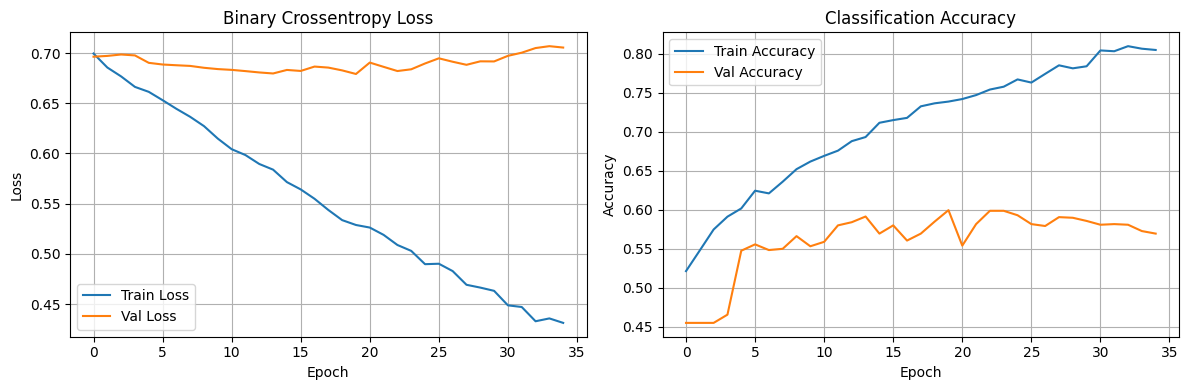

In [ ]:
# Training curves for both outputs
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Total loss
axes[0,0].plot(history.history['loss'], label='Train')
axes[0,0].plot(history.history['val_loss'], label='Val')
axes[0,0].set_title('Total Loss')
axes[0,0].legend()
axes[0,0].grid()

# Direction loss
axes[0,1].plot(history.history['direction_loss'], label='Train')
axes[0,1].plot(history.history['val_direction_loss'], label='Val')
axes[0,1].set_title('Direction Loss (BCE)')
axes[0,1].legend()
axes[0,1].grid()

# Magnitude loss
axes[0,2].plot(history.history['magnitude_loss'], label='Train')
axes[0,2].plot(history.history['val_magnitude_loss'], label='Val')
axes[0,2].set_title('Magnitude Loss (MSE)')
axes[0,2].legend()

axes[0,2].grid()plt.show()

plt.tight_layout()

# Direction accuracy

axes[1,0].plot(history.history['direction_accuracy'], label='Train')axes[1,2].grid()

axes[1,0].plot(history.history['val_direction_accuracy'], label='Val')axes[1,2].legend()

axes[1,0].set_title('Direction Accuracy')axes[1,2].set_title('Magnitude MAE')

axes[1,0].legend()axes[1,2].plot(history.history['val_magnitude_mae'], label='Val')

axes[1,0].grid()axes[1,2].plot(history.history['magnitude_mae'], label='Train')

# Magnitude MAE

# Direction AUC

axes[1,1].plot(history.history['direction_auc'], label='Train')axes[1,1].grid()

axes[1,1].plot(history.history['val_direction_auc'], label='Val')axes[1,1].legend()
axes[1,1].set_title('Direction AUC')


BINARY CLASSIFIER EVALUATION

Classification Report:
              precision    recall  f1-score   support

        DOWN       0.46      0.89      0.61       713
          UP       0.53      0.11      0.18       829

    accuracy                           0.47      1542
   macro avg       0.50      0.50      0.39      1542
weighted avg       0.50      0.47      0.38      1542



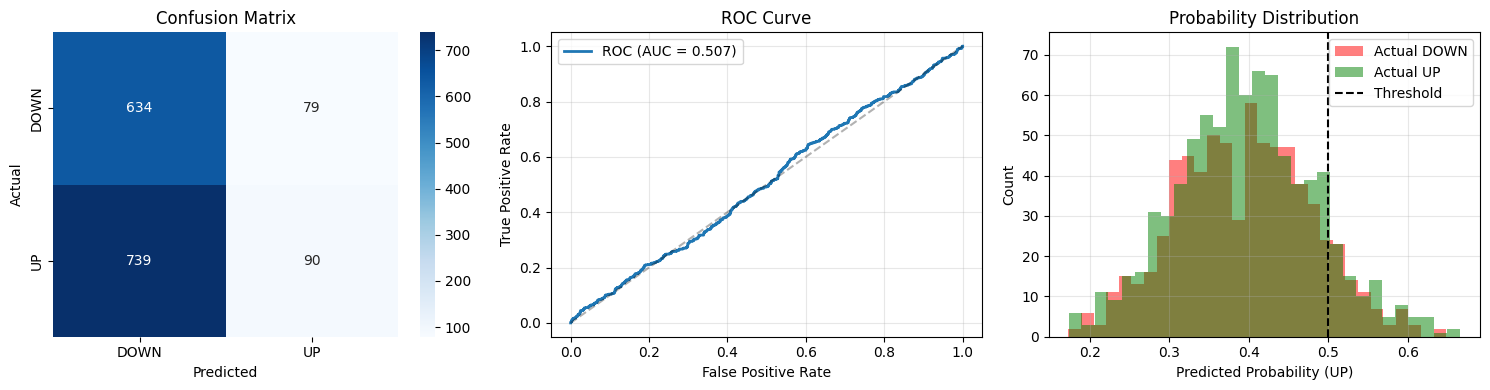

In [ ]:
# ============================================================================
# Multi-Output Predictions
# ============================================================================
print("="*60)
print("MULTI-OUTPUT MODEL EVALUATION")
print("="*60)

# Get predictions for both outputs
predictions = model.predict(X_test, verbose=0)
y_pred_dir_proba = predictions[0].flatten()
y_pred_mag = predictions[1].flatten()

# Binary direction predictions
y_pred_dir = (y_pred_dir_proba > 0.5).astype(int)

# ========== Direction Head Evaluation ==========
print("\n--- Direction Head (UP vs DOWN) ---")
cm_dir = confusion_matrix(y_test_dir, y_pred_dir)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Confusion matrix
sns.heatmap(cm_dir, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Direction: Confusion Matrix')
axes[0].set_xticklabels(['DOWN', 'UP'])
axes[0].set_yticklabels(['DOWN', 'UP'])

# ROC curve
fpr_dir, tpr_dir, _ = roc_curve(y_test_dir, y_pred_dir_proba)
auc_dir = roc_auc_score(y_test_dir, y_pred_dir_proba)

axes[1].plot(fpr_dir, tpr_dir, label=f'ROC (AUC = {auc_dir:.3f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Direction: ROC Curve')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Probability distribution
axes[2].hist(y_pred_dir_proba[y_test_dir==0], bins=30, alpha=0.5, label='Actual DOWN', color='red')
axes[2].hist(y_pred_dir_proba[y_test_dir==1], bins=30, alpha=0.5, label='Actual UP', color='green')
axes[2].axvline(0.5, color='black', linestyle='--', label='Threshold')
axes[2].set_xlabel('Predicted Probability (UP)')
axes[2].set_ylabel('Count')

axes[2].set_title('Direction: Probability Distribution')plt.show()

axes[2].legend()plt.tight_layout()

axes[2].grid(alpha=0.3)

axes[2].grid(alpha=0.3)

plt.tight_layout()axes[2].set_title('Magnitude: Residual Distribution')

plt.show()axes[2].set_ylabel('Count')

axes[2].set_xlabel('Residuals')

print("\nDirection Classification Report:")axes[2].axvline(0, color='r', linestyle='--', lw=2)

print(classification_report(y_test_dir, y_pred_dir, target_names=['DOWN', 'UP']))axes[2].hist(residuals, bins=50, alpha=0.7, edgecolor='black')

# Distribution

# ========== Magnitude Head Evaluation ==========

print("\n--- Magnitude Head (% Price Change Regression) ---")axes[1].grid(alpha=0.3)

axes[1].set_title('Magnitude: Residual Plot')

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_scoreaxes[1].set_ylabel('Residuals')

axes[1].set_xlabel('Predicted % Change')

mae_mag = mean_absolute_error(y_test_mag, y_pred_mag)axes[1].axhline(0, color='r', linestyle='--', lw=2)

mse_mag = mean_squared_error(y_test_mag, y_pred_mag)axes[1].scatter(y_pred_mag, residuals, alpha=0.3, s=10)

rmse_mag = np.sqrt(mse_mag)residuals = y_test_mag - y_pred_mag

r2_mag = r2_score(y_test_mag, y_pred_mag)# Residuals



print(f"MAE: {mae_mag:.6f}")axes[0].grid(alpha=0.3)

print(f"MSE: {mse_mag:.8f}")axes[0].set_title('Magnitude: Actual vs Predicted')

print(f"RMSE: {rmse_mag:.6f}")axes[0].set_ylabel('Predicted % Change')

print(f"R² Score: {r2_mag:.4f}")axes[0].set_xlabel('Actual % Change')

axes[0].plot([y_test_mag.min(), y_test_mag.max()], [y_test_mag.min(), y_test_mag.max()], 'r--', lw=2)

# Magnitude visualizationaxes[0].scatter(y_test_mag, y_pred_mag, alpha=0.3, s=10)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))# Actual vs Predicted


## 7. Save Outputs

In [ ]:
# Save model
model.save('eth_multioutput_model.h5')
print("Model saved: eth_multioutput_model.h5")

# Save metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, r2_score

# Combined analysis
direction_matches_magnitude_sign = (y_pred_dir == y_test_dir) & (np.sign(y_pred_mag) == np.sign(y_test_mag))
high_conf_threshold = 0.7
high_confidence_mask = (y_pred_dir_proba > high_conf_threshold) | (y_pred_dir_proba < (1 - high_conf_threshold))
high_conf_accuracy = (y_pred_dir[high_confidence_mask] == y_test_dir[high_confidence_mask]).mean() if high_confidence_mask.sum() > 0 else None

metrics = {
    'model_type': 'multi_output',
    'architecture': 'CNN-LSTM with two heads (Direction + Magnitude)',
    'num_datasets': metadata['num_datasets'],
    'total_samples': metadata['total_samples'],
    'threshold': metadata['threshold'],
    'horizon': metadata['horizon'],
    'test_samples': int(len(y_test_dir)),
    
    'direction_head': {
        'task': 'Binary classification (UP vs DOWN)',
        'accuracy': float(accuracy_score(y_test_dir, y_pred_dir)),
        'precision': float(precision_score(y_test_dir, y_pred_dir, average='binary')),
        'recall': float(recall_score(y_test_dir, y_pred_dir, average='binary')),
        'f1': float(f1_score(y_test_dir, y_pred_dir, average='binary')),
        'roc_auc': float(auc_dir)
    },
    
    'magnitude_head': {
        'task': 'Regression (% price change)',
        'mae': float(mae_mag),
        'mse': float(mse_mag),
        'rmse': float(rmse_mag),
        'r2_score': float(r2_mag)
    },
    
    'combined_analysis': {
        'direction_magnitude_alignment': float(direction_matches_magnitude_sign.mean()),
        'high_confidence_trades': {
            'count': int(high_confidence_mask.sum()),
            'percentage': float(high_confidence_mask.mean()),
            'accuracy': float(high_conf_accuracy) if high_confidence_mask.sum() > 0 else None
        }
    }

}          f"({metrics['combined_analysis']['high_confidence_trades']['percentage']*100:.1f}% of samples)")

    print(f"High Confidence Accuracy: {metrics['combined_analysis']['high_confidence_trades']['accuracy']:.4f} " 

with open('eth_multioutput_metrics.json', 'w') as f:if metrics['combined_analysis']['high_confidence_trades']['accuracy']:

    json.dump(metrics, f, indent=2)print(f"Direction-Magnitude Alignment: {metrics['combined_analysis']['direction_magnitude_alignment']:.4f}")

print(f"Magnitude Head: {metrics['magnitude_head']['mae']:.6f} MAE, {metrics['magnitude_head']['r2_score']:.4f} R²")

print("\nMetrics saved: eth_multioutput_metrics.json")print(f"Direction Head: {metrics['direction_head']['accuracy']:.4f} accuracy, {metrics['direction_head']['roc_auc']:.4f} AUC")
print("\n=== Multi-Output Model Summary ===")

Model saved: eth_binary_classifier.h5

Metrics saved: eth_binary_classifier_metrics.json

=== Binary Classifier Summary ===
Accuracy: 0.4695
Precision: 0.5325
Recall: 0.1086
F1-Score: 0.1804
ROC AUC: 0.5068
